In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind 
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import normaltest

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

In [2]:
ecmodf_analysis = pd.read_csv('ecmodf_analysis_manualedits.csv', index_col=0)
ecmodf_analysis['sex'] = ecmodf_analysis['sex'].astype('bool')
ecmodf_analysis['death'] = ecmodf_analysis['death'].astype('bool')
ecmodf_analysis['rrt'] = ecmodf_analysis['rrt'].astype('bool')
ecmodf_analysis['ptx'] = ecmodf_analysis['ptx'].astype('bool')
ecmodf_analysis['pe'] = ecmodf_analysis['pe'].astype('bool')
ecmodf_analysis['bronchinf'] = ecmodf_analysis['bronchinf'].astype('bool')
ecmodf_analysis['ethnic'] = ecmodf_analysis['ethnic'].astype('object')
del ecmodf_analysis['admit_date']
del ecmodf_analysis['hosp']

In [3]:
ecmodf_analysis.head()

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,cluster,sex,death,time,ethnic,resp,na,rrt,pe,ptx,deathmod,cth,bronch0,bronchinf
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.0,2,4,48.750000,6.0000,29.00,0.4,24.0,0.800000,1609,306,7.2,10.3,2,False,False,21,2,6,0.48,True,False,True,NaN,NaN,NaN,False
2,34,37,6.0,1,4,76.500000,9.8918,29.36,0.5,31.2,12.336727,115,217,4.1,80.0,2,True,False,12,1,7,0.10,False,False,False,NaN,NaN,NaN,False
3,66,26,6.0,1,10,61.578947,7.5500,28.00,0.3,19.3,6.290000,5534,409,7.1,80.0,2,False,False,12,0,4,0.94,True,True,False,NaN,NaN,NaN,False
4,34,36,0.0,2,6,72.187500,7.1000,30.00,1.9,9.6,1.210000,267,388,7.1,7.4,1,True,False,19,2,5,0.08,False,False,False,NaN,NaN,candida,False
5,53,42,1.0,2,12,80.833333,9.3000,31.00,0.8,7.4,100.000000,6023,665,5.9,73.3,0,False,True,13,1,3,0.45,True,False,True,death_mof,NaN,NaN,False


## Exploratory analysis of SOFA/RESP/age/pfr/pCO2 prediction of mortality

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [5]:
regdf = ecmodf_analysis.loc[:, ['death', 'sofa', 'age', 'resp', 'pfr', 'pco2', 'ddim']]
regdf['ddim'] = np.log2(regdf['ddim'])
regdf.groupby('death').mean()

,sofa,age,resp,pfr,pco2,ddim
death,,,,,,
False,6.1500,43.95,4.625,71.253700,8.912635,3.202010
True,8.4375,49.25,3.625,66.135626,9.583462,4.675161


In [6]:
#y = predicted outcome
y = np.asarray(regdf['death'])
y.shape

(56,)

In [7]:
#X = array of independent variable(s)
ind = ['resp', 'sofa', 'ddim'] ## <------ modify chosen variables here

x0 = np.asarray(regdf.loc[:, ind])

X = x0.reshape(56, len(ind))
X.shape

(56, 3)

In [8]:
X[:10]

array([[ 6.        ,  4.        ,  3.36457243],
       [ 7.        ,  4.        ,  6.32192809],
       [ 4.        , 10.        ,  6.32192809],
       [ 5.        ,  6.        ,  2.88752527],
       [ 3.        , 12.        ,  6.19574129],
       [ 2.        ,  4.        ,  4.60880924],
       [ 2.        , 10.        ,  5.55151602],
       [ 3.        ,  9.        ,  4.96347412],
       [ 2.        , 13.        ,  5.44956137],
       [ 3.        , 11.        ,  3.71149491]])

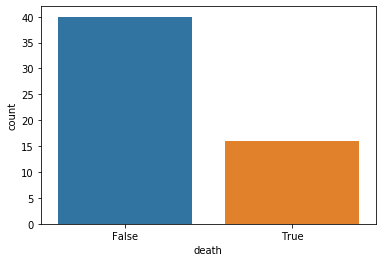

In [9]:
sns.countplot(x = 'death', data = regdf)

# Most ML algorithms have poor performance on minority class.
# I.e. - most results are in category A, therefore will predict category A most of the time
# SMOTE (synthetic minority oversampling technique) will synthesize new samples for minority classes using existing data
# This doesn't add new information to the model but improves model performance
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)

#==> Currently doesn't not work due to version dependencies
#==> So using "class_weights = "balanced" instead, which attempts to balance classes in model using artifical weighting

plt.show()

In [10]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X) 

result=logit_model.fit()
print(result.summary()) 

Optimization terminated successfully.
         Current function value: 0.491344
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   56
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:                  0.1787
Time:                        20:23:14   Log-Likelihood:                -27.515
converged:                       True   LL-Null:                       -33.503
Covariance Type:            nonrobust   LLR p-value:                  0.002509
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.6230      0.179     -3.485      0.000      -0.973      -0.273
x2             0.0450      0.

In [11]:
##coef = regression coefficient (b1) = estimated increase in the log odds of outcome per integer unit increase in value of exposure
##give other exposure remaining same in multiple regression. Coef gives idea of effect size and direction
##p-value <0.05 if effect is statistically significant

OR = np.exp(result.params) #odds ratio - per integer unit increment - converted back from log odds by e^b1
CI =  np.exp(result.conf_int()) #confidence interval for odds ratio

odds_ratios = pd.DataFrame()

odds_ratios['var'] = pd.Series(ind)
odds_ratios['odds ratio'] = pd.Series(OR)
odds_ratios = pd.concat([odds_ratios, pd.DataFrame(CI)], axis=1)
#odds_ratios['CI1'] = pd.Series(CI)

odds_ratios

,var,odds ratio,0,1
0,resp,0.536336,0.377822,0.761354
1,sofa,1.046057,0.854545,1.280488
2,ddim,1.421876,0.932227,2.168713


In [12]:
np.exp(result.conf_int()) #confidence interval for odds ratio

array([[0.37782208, 0.7613542 ],
       [0.85454493, 1.28048825],
       [0.93222673, 2.16871274]])

In [13]:
#weights = {0 : '0.28', 1 : '0.72'}

model = LogisticRegression(solver='liblinear', class_weight="balanced", C = 0.5, penalty='l1', random_state=0)
#low C help prevent overfitting in small dataset
model.fit(X, y)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

       False       0.86      0.75      0.80        40
        True       0.52      0.69      0.59        16

    accuracy                           0.73        56
   macro avg       0.69      0.72      0.70        56
weighted avg       0.76      0.73      0.74        56



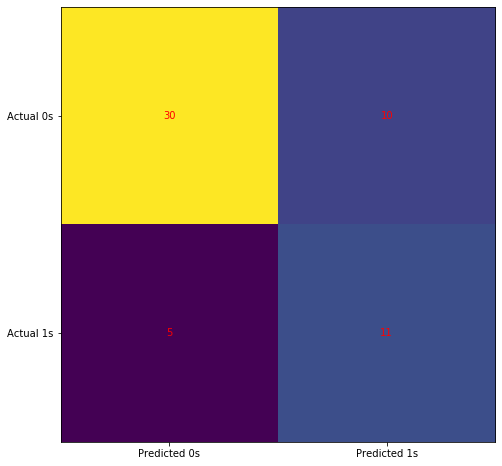

In [15]:
cm = confusion_matrix(y, model.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        
plt.show()

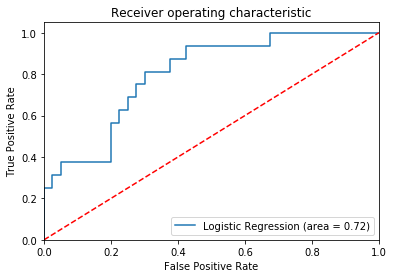

In [16]:
logit_roc_auc = roc_auc_score(y, model.predict(X))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

## Adding membership of clusters into model

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [18]:
temp = ecmodf_analysis.copy()

temp = pd.concat([temp, pd.get_dummies(temp['cluster'], prefix = 'cluster')], axis=1)
temp.drop('cluster', inplace=True, axis=1)

##hypoinflammatory
#temp.loc[temp['cluster'] == 2, 'cluster'] = 0

##septic
#temp.loc[temp['cluster'] == 1, 'cluster'] = 2
#temp.loc[temp['cluster'] == 0, 'cluster'] = 1
#temp.loc[temp['cluster'] == 2, 'cluster'] = 0

##fulminant
#temp.loc[temp['cluster'] == 1, 'cluster'] = 0
#temp.loc[temp['cluster'] == 2, 'cluster'] = 1

temp.head()




,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,sex,death,time,ethnic,resp,na,rrt,pe,ptx,deathmod,cth,bronch0,bronchinf,cluster_0,cluster_1,cluster_2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.0,2,4,48.750000,6.0000,29.00,0.4,24.0,0.800000,1609,306,7.2,10.3,False,False,21,2,6,0.48,True,False,True,NaN,NaN,NaN,False,0,0,1
2,34,37,6.0,1,4,76.500000,9.8918,29.36,0.5,31.2,12.336727,115,217,4.1,80.0,True,False,12,1,7,0.10,False,False,False,NaN,NaN,NaN,False,0,0,1
3,66,26,6.0,1,10,61.578947,7.5500,28.00,0.3,19.3,6.290000,5534,409,7.1,80.0,False,False,12,0,4,0.94,True,True,False,NaN,NaN,NaN,False,0,0,1
4,34,36,0.0,2,6,72.187500,7.1000,30.00,1.9,9.6,1.210000,267,388,7.1,7.4,True,False,19,2,5,0.08,False,False,False,NaN,NaN,candida,False,0,1,0
5,53,42,1.0,2,12,80.833333,9.3000,31.00,0.8,7.4,100.000000,6023,665,5.9,73.3,False,True,13,1,3,0.45,True,False,True,death_mof,NaN,NaN,False,1,0,0


In [19]:
regdf = temp.loc[:, ['death', 'sofa', 'age', 'resp', 'cluster_0', 'cluster_1', 'cluster_2', 'rrt', 'ddim']]
regdf['ddim'] = np.log2(regdf['ddim'])
regdf.head()

,death,sofa,age,resp,cluster_0,cluster_1,cluster_2,rrt,ddim
id,,,,,,,,,
1,False,4,46,6,0,0,1,True,3.364572
2,False,4,34,7,0,0,1,False,6.321928
3,False,10,66,4,0,0,1,True,6.321928
4,False,6,34,5,0,1,0,False,2.887525
5,True,12,53,3,1,0,0,True,6.195741


In [20]:
#y = predicted outcome
y = np.asarray(regdf['rrt'])
y.shape

(56,)

In [21]:
#X = array of independent variable(s)
ind = ['cluster_1', 'cluster_0', 'sofa', 'resp'] ## modify chosen variables here

x0 = np.asarray(regdf.loc[:, ind])

X = x0.reshape(56, len(ind))
X.shape

(56, 4)

In [22]:
X[:10]

array([[ 0,  0,  4,  6],
       [ 0,  0,  4,  7],
       [ 0,  0, 10,  4],
       [ 1,  0,  6,  5],
       [ 0,  1, 12,  3],
       [ 0,  1,  4,  2],
       [ 0,  1, 10,  2],
       [ 0,  1,  9,  3],
       [ 0,  1, 13,  2],
       [ 0,  1, 11,  3]], dtype=int64)

In [23]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X)

result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.509650
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   56
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            3
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:                  0.2393
Time:                        20:23:18   Log-Likelihood:                -28.540
converged:                       True   LL-Null:                       -37.521
Covariance Type:            nonrobust   LLR p-value:                 0.0004482
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6897      0.760     -2.222      0.026      -3.180      -0.199
x2            -0.3806      0.

In [24]:
OR = np.exp(result.params) #odds ratio 
CI =  np.exp(result.conf_int()) #confidence interval for odds ratio

odds_ratios = pd.DataFrame()

odds_ratios['var'] = pd.Series(ind)
odds_ratios['odds ratio'] = pd.Series(OR)
odds_ratios = pd.concat([odds_ratios, pd.DataFrame(CI)], axis=1)
#odds_ratios['CI1'] = pd.Series(CI)

odds_ratios

,var,odds ratio,0,1
0,cluster_1,0.184576,0.041590,0.819156
1,cluster_0,0.683472,0.148182,3.152431
2,sofa,1.292535,1.045719,1.597605
3,resp,0.739373,0.550514,0.993022


In [25]:
model = LogisticRegression(solver='liblinear', class_weight="balanced", penalty='l1', C = 1.0, random_state=0)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
print(classification_report(y, model.predict(X)))

              precision    recall  f1-score   support

       False       0.81      0.74      0.77        34
        True       0.64      0.73      0.68        22

    accuracy                           0.73        56
   macro avg       0.72      0.73      0.73        56
weighted avg       0.74      0.73      0.73        56



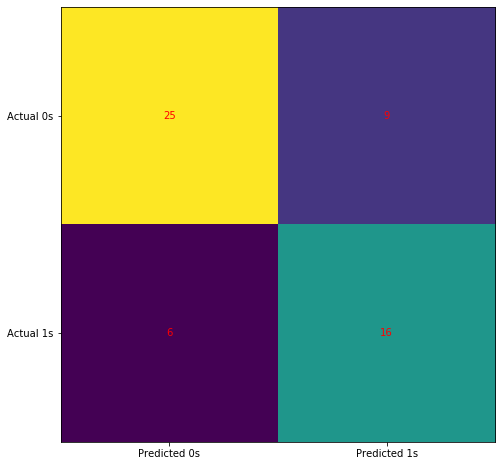

In [27]:
cm = confusion_matrix(y, model.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
        
plt.show()

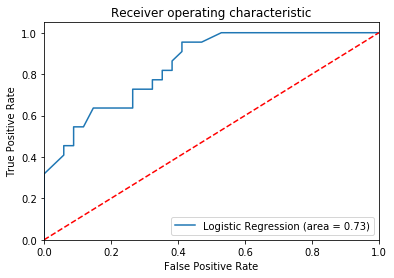

In [28]:
logit_roc_auc = roc_auc_score(y, model.predict(X))
fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')

plt.show()

## k-folds cross validation

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

from numpy import mean
from numpy import std

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 500)

In [2]:
ecmodf_analysis = pd.read_csv('ecmodf_analysis_manualedits.csv', index_col=0)
ecmodf_analysis['sex'] = ecmodf_analysis['sex'].astype('bool')
ecmodf_analysis['death'] = ecmodf_analysis['death'].astype('bool')
ecmodf_analysis['rrt'] = ecmodf_analysis['rrt'].astype('bool')
ecmodf_analysis['ptx'] = ecmodf_analysis['ptx'].astype('bool')
ecmodf_analysis['pe'] = ecmodf_analysis['pe'].astype('bool')
ecmodf_analysis['bronchinf'] = ecmodf_analysis['bronchinf'].astype('bool')
ecmodf_analysis['ethnic'] = ecmodf_analysis['ethnic'].astype('object')
del ecmodf_analysis['admit_date']
del ecmodf_analysis['hosp']

ecmodf_comorb = pd.read_csv('ecmodf_analysis_comorb.csv', index_col=0)
ecmodf_steroids = pd.read_csv('ecmodf_analysis_steroids.csv', index_col=0)
ecmodf_analysis = pd.concat([ecmodf_analysis, ecmodf_comorb], axis=1)
ecmodf_analysis = pd.concat([ecmodf_analysis, ecmodf_steroids], axis=1)

In [3]:
temp = ecmodf_analysis.copy()

temp = pd.concat([temp, pd.get_dummies(temp['cluster'], prefix = 'cluster')], axis=1)
temp.drop('cluster', inplace=True, axis=1)

temp

,age,bmi,ed_v,v_vv,sofa,pfr,pco2,pplat,lymph,nlrat,pct,ferritin,crp,fib,ddim,sex,death,time,ethnic,resp,na,rrt,pe,ptx,deathmod,cth,bronch0,bronchinf,diabetes,asthma,hypertension,presteroid,ecmosteroid,ttsteroids,cluster_0,cluster_1,cluster_2
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,46,34,3.000000,2,4,48.750000,6.0000,29.00,0.4,24.000000,0.800000,1609,306,7.2,10.300000,False,False,21,2,6,0.48,True,False,True,NaN,NaN,NaN,False,0,1,0,0,0,NaN,0,0,1
2,34,37,6.000000,1,4,76.500000,9.8918,29.36,0.5,31.200000,12.336727,115,217,4.1,80.000000,True,False,12,1,7,0.10,False,False,False,NaN,NaN,NaN,False,0,0,0,0,0,NaN,0,0,1
3,66,26,6.000000,1,10,61.578947,7.5500,28.00,0.3,19.300000,6.290000,5534,409,7.1,80.000000,False,False,12,0,4,0.94,True,True,False,NaN,NaN,NaN,False,0,0,0,0,1,3.0,0,0,1
4,34,36,0.000000,2,6,72.187500,7.1000,30.00,1.9,9.600000,1.210000,267,388,7.1,7.400000,True,False,19,2,5,0.08,False,False,False,NaN,NaN,candida,False,0,1,0,0,1,8.0,0,1,0
5,53,42,1.000000,2,12,80.833333,9.3000,31.00,0.8,7.400000,100.000000,6023,665,5.9,73.300000,False,True,13,1,3,0.45,True,False,True,death_mof,NaN,NaN,False,0,0,1,0,1,4.0,1,0,0
6,55,28,3.000000,6,4,66.000000,12.0000,30.00,0.4,22.500000,6.430000,3800,460,10.0,24.400000,False,False,7,1,2,0.00,True,False,False,NaN,cth_bleed,NaN,False,0,0,1,0,1,2.0,1,0,0
7,52,26,0.000000,7,10,68.250000,14.0000,32.00,0.7,14.400000,17.220000,1253,355,7.8,46.900000,False,True,5,1,2,0.25,True,False,False,death_ich,cth_bleed,NaN,False,1,0,1,0,0,NaN,1,0,0
8,57,22,0.000000,5,9,67.500000,9.0000,27.00,0.9,11.100000,9.540000,1903,596,11.5,31.200000,False,False,13,1,3,0.46,True,False,True,NaN,NaN,ecoli,True,0,0,0,0,1,11.0,1,0,0
9,53,27,1.000000,6,13,65.250000,11.5000,26.00,1.8,8.300000,55.650000,6561,355,6.6,43.700000,False,True,3,0,2,0.11,True,False,True,death_tamponade,cth_bleed,candida,False,0,0,0,0,0,NaN,1,0,0


In [4]:
regdf = temp.loc[:, ['death', 'sofa', 'age', 'resp', 'cluster_0', 'cluster_1', 'cluster_2', 'rrt', 'ddim', 'v_vv', 'bmi', 'ferritin', 'presteroid', 'hypertension', 'diabetes']]
regdf['ddim'] = np.log2(regdf['ddim'])
regdf

,death,sofa,age,resp,cluster_0,cluster_1,cluster_2,rrt,ddim,v_vv,bmi,ferritin,presteroid,hypertension,diabetes
id,,,,,,,,,,,,,,,
1,False,4,46,6,0,0,1,True,3.364572,2,34,1609,0,0,0
2,False,4,34,7,0,0,1,False,6.321928,1,37,115,0,0,0
3,False,10,66,4,0,0,1,True,6.321928,1,26,5534,0,0,0
4,False,6,34,5,0,1,0,False,2.887525,2,36,267,0,0,0
5,True,12,53,3,1,0,0,True,6.195741,2,42,6023,0,1,0
6,False,4,55,2,1,0,0,True,4.608809,6,28,3800,0,1,0
7,True,10,52,2,1,0,0,True,5.551516,7,26,1253,0,1,1
8,False,9,57,3,1,0,0,True,4.963474,5,22,1903,0,0,0
9,True,13,53,2,1,0,0,True,5.449561,6,27,6561,0,0,0


In [5]:
#y = predicted outcome
y = np.asarray(regdf['rrt'])
y.shape

(56,)

In [6]:
#X = array of independent variable(s)
ind = ['sofa', 'resp', 'cluster_1'] ## modify chosen variables here

x0 = np.asarray(regdf.loc[:, ind])

X = x0.reshape(56, len(ind))
X.shape

(56, 3)

In [7]:
import statsmodels.api as sm

logit_model=sm.Logit(y,X)

result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.511802
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   56
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Oct 2020   Pseudo R-squ.:                  0.2361
Time:                        22:13:47   Log-Likelihood:                -28.661
converged:                       True   LL-Null:                       -37.521
Covariance Type:            nonrobust   LLR p-value:                 0.0001420
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2279      0.090      2.535      0.011       0.052       0.404
x2            -0.3009      0.

In [8]:
OR = np.exp(result.params) #odds ratio 
CI =  np.exp(result.conf_int()) #confidence interval for odds ratio

odds_ratios = pd.DataFrame()

odds_ratios['var'] = pd.Series(ind)
odds_ratios['odds ratio'] = pd.Series(OR)
odds_ratios = pd.concat([odds_ratios, pd.DataFrame(CI)], axis=1)
#odds_ratios['CI1'] = pd.Series(CI)

odds_ratios

,var,odds ratio,0,1
0,sofa,1.256018,1.053056,1.498096
1,resp,0.740168,0.549912,0.996247
2,cluster_1,0.217387,0.057434,0.822808


In [9]:
kfold = KFold(n_splits=4) # Define the split
kfold.get_n_splits(X) # returns the number of splitting iterations in the cross-validator

print(kfold) 

KFold(n_splits=4, random_state=None, shuffle=False)


In [10]:
for train_index, test_index in kfold.split(X):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55] TEST: [14 15 16 17 18 19 20 21 22 23 24 25 26 27]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 42 43 44 45 46 47 48 49 50 51 52 53 54 55] TEST: [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41] TEST: [42 43 44 45 46 47 48 49 50 51 52 53 54 55]


In [11]:
model = LogisticRegression(solver='liblinear', class_weight="balanced", penalty='l1', C = 1.0, random_state=0)
model.fit(X, y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=kfold, n_jobs=-1)

##options for scoring: accuracy, roc_auc, precision, f1

In [13]:
print(scores)

[0.86363636 0.8030303  0.575      0.9       ]


In [14]:
print('ROC AUC: %.3f (%.3f)' % (mean(scores), std(scores)))

ROC AUC: 0.785 (0.126)
